# Notebook to generate psychometrics plot given sessions & conditions

In [1]:
from scripts.conf_file_finding import try_find_conf_file
try_find_conf_file()

import datajoint as dj
from datetime import date, datetime, timedelta
import pandas as pd
import numpy as np
import pylab as plt
import matplotlib.patches as mpatches

from matplotlib import cm
from u19_pipeline import utility
from inspect import getmembers, isfunction
import u19_pipeline.alert_system.behavior_metrics as bm
import copy


Local configuration file found !!, no need to run the configuration (unless configuration has changed)


### Datajoint configuration and Connection to DB

In [20]:
dj.conn()
acquisition = dj.create_virtual_module('acquisition', 'u19_acquisition')
behavior = dj.create_virtual_module('behavior', 'u19_behavior')

### Find all protocols

In [3]:

all_protocols_df = pd.DataFrame(acquisition.Session.fetch('session_protocol', as_dict=True))
all_protocols_df = all_protocols_df.groupby('session_protocol').agg({'session_protocol': [('num_sessions', 'count')]})
all_protocols_df.columns = all_protocols_df.columns.droplevel()
all_protocols_df = all_protocols_df.sort_values(by='num_sessions', ascending=False)
all_protocols_df = all_protocols_df.loc[all_protocols_df['num_sessions'] > 100, :]
all_protocols_df

,num_sessions
session_protocol,
poisson_blocks.m poisson_blocks_reboot_3m.mat PoissonBlocksCondensed3m,12439
poisson_blocks_PuffAndTower.m poisson_blocks_reboot_3m.mat PoissonBlocksCondensed3m,3288
poisson_patches_laser.m poisson_blocks_reboot_laser.mat PoissonBlocksReboot3m,1899
poisson_blocks.m poisson_blocks_reboot_3m.mat PoissonBlocksCondensed3m_manuel,1836
josh_poisson_blocks_noTowers_TTL.m josh_poisson_blocks_noTowers_TTL.mat PoissonBlocksContext_visualTurnGuide_ArcTag_josh,1435
...,...
LSTT_MovieLike_TrialStructure_EF.m LSTT_MovieLike_World_EF.mat LSTT_Levels_FirstDistractors_EF,123
poisson_blocks_laser_scott.m poisson_blocks_laser_scott.mat PoissonBlocksCondensed3m_Scott,122
LSTT_Stationary_TrialStructure_EF.m LSTT_Stationary_WorldInvisible_EF.mat LSTT_Levels_FirstDistractors_Stationary_EF,116


In [4]:
session_protocol_q = 'session_protocol = "' +all_protocols_df.index[1] + '"'
session_protocol_q

'session_protocol = "poisson_blocks_PuffAndTower.m poisson_blocks_reboot_3m.mat PoissonBlocksCondensed3m"'

### Subjects that trained this week vs already finished training

In [5]:
today = date.today() + timedelta(days=-1)
start_week = today - timedelta(days=today.weekday())
#end_lastweek = start_week - timedelta(days=1)
start_week_str =  start_week.strftime('%Y-%m-%d')
#end_lastweek_str =  end_lastweek.strftime('%Y-%m-%d')

query_old_subjects = 'session_date <= "'+ start_week_str + '"'
query_new_subjects = 'session_date > "'+ start_week_str + '"'
not_testuser       = 'subject_fullname not like "testuser%"'
not_testsubjects   = 'subject_fullname not like "%_test"'
not_bad_sessions   = 'is_bad_session = 0'
base_query         = [session_protocol_q, not_testuser, not_testsubjects, not_bad_sessions]

query_old_subjects    = [query_old_subjects] + base_query
query_new_subjects   =  [query_new_subjects] + base_query

base_session_table_filtered = acquisition.Session & base_query
session_table_filtered      = copy.deepcopy(base_session_table_filtered)
for filter_key in query_old_subjects:
    session_table_filtered = session_table_filtered & filter_key
subject_old_sessions = set((session_table_filtered).fetch('subject_fullname').tolist())

session_table_filtered      = copy.deepcopy(base_session_table_filtered)
for filter_key in query_new_subjects:
    session_table_filtered = session_table_filtered & filter_key
subject_new_sessions = set((session_table_filtered).fetch('subject_fullname').tolist())

subjects_only_old = list(subject_old_sessions - subject_new_sessions)

subjects_only_oldquery = [{'subject_fullname': i} for i in subjects_only_old]
subjects_new_sessions_query = [{'subject_fullname': i} for i in subject_new_sessions]

print('subjects this protocol did not train this week: ', len(subjects_only_oldquery))
print('subjects this protocol did train this week: ', len(subjects_new_sessions_query))

subjects this protocol did not train this week:  116
subjects this protocol did train this week:  7


In [6]:
session_old_df = pd.DataFrame((base_session_table_filtered & subjects_only_oldquery).fetch('KEY','session_protocol',  'level',order_by='session_start_time', as_dict=True))
session_new_df = pd.DataFrame((base_session_table_filtered & subjects_new_sessions_query).fetch('KEY','session_protocol', 'level', order_by='session_start_time', as_dict=True))

print('Sessions this protocol from subjects did not train this week: ', session_old_df.shape[0])

Sessions this protocol from subjects did not train this week:  5100


In [7]:
session_new_df

,subject_fullname,session_date,session_number,level,session_protocol
0,jounhong_CaMKIIa_tetO_75,2022-07-13,0,1,poisson_blocks_PuffAndTower.m poisson_blocks_r...
1,jounhong_CaMKIIa_tetO_83,2022-07-13,0,2,poisson_blocks_PuffAndTower.m poisson_blocks_r...
2,jounhong_CaMKIIa_tetO_75,2022-07-14,0,1,poisson_blocks_PuffAndTower.m poisson_blocks_r...
3,jounhong_CaMKIIa_tetO_83,2022-07-14,0,2,poisson_blocks_PuffAndTower.m poisson_blocks_r...
4,jounhong_CaMKIIa_tetO_75,2022-07-15,0,1,poisson_blocks_PuffAndTower.m poisson_blocks_r...
...,...,...,...,...,...
148,jounhong_CaMKIIa_tetO_740,2022-10-17,0,11,poisson_blocks_PuffAndTower.m poisson_blocks_r...
149,jounhong_CaMKIIa_tetO_83,2022-10-17,0,11,poisson_blocks_PuffAndTower.m poisson_blocks_r...
150,jounhong_CaMKIIa_tetO_762,2022-10-17,0,1,poisson_blocks_PuffAndTower.m poisson_blocks_r...
151,jounhong_CaMKIIa_tetO_75,2022-10-17,0,11,poisson_blocks_PuffAndTower.m poisson_blocks_r...


### Level distribution (max level ~98 percentile)

11.0

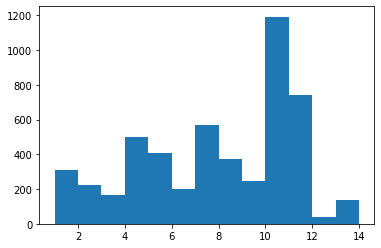

In [8]:
max_level_calculated = np.percentile(session_old_df['level'].values, 90)
plt.hist(session_old_df['level'].values, bins=session_old_df['level'].max()-1)
max_level_calculated

In [14]:
level_query = 'level >= '+ str(max_level_calculated)
session_table_filtered = base_session_table_filtered & subjects_only_oldquery & level_query
subjects_only_old_level = set((session_table_filtered).fetch('subject_fullname').tolist())
subjects_only_oldquery_level = [{'subject_fullname': i} for i in subjects_only_old_level]
session_old_df = pd.DataFrame((base_session_table_filtered & subjects_only_oldquery_level).fetch('KEY', 'level', 'session_location',order_by='session_start_time', as_dict=True))
print('subjects this protocol did not train this week to get to max level: ', len(subjects_only_oldquery_level))
print('Sessions this protocol from subjects did not train this week that got to max level: ', session_old_df.shape[0])

subjects this protocol did not train this week to get to max level:  58
Sessions this protocol from subjects did not train this week that got to max level:  3501


In [17]:
# Count sessions for each subject (sequential count and total count)
session_old_df = session_old_df.sort_values(by=['subject_fullname', 'session_date', 'session_number'])

sequential_sessions = session_old_df.groupby(['subject_fullname']).cumcount() + 1
num_sessions_df = session_old_df.groupby('subject_fullname').agg({'session_date': [('total_sessions', 'count')]})
num_sessions_df.columns = num_sessions_df.columns.droplevel()
num_sessions_df = num_sessions_df.reset_index()

#num_sessions_level_df = session_old_df.groupby(['subject_fullname').agg({'session_date': [('total_sessions', 'count')]})
#num_sessions_df.columns = num_sessions_df.columns.droplevel()
#num_sessions_df = num_sessions_df.reset_index()

session_old_df['seq_sessions'] = sequential_sessions
session_old_df = session_old_df.merge(num_sessions_df)

session_old_df

,subject_fullname,session_date,session_number,session_location,level,seq_sessions,total_sessions
0,jounhong_CaMKII_tetO_7,2021-06-14,0,Bezos2,2,1,52
1,jounhong_CaMKII_tetO_7,2021-06-15,0,Bezos2,2,2,52
2,jounhong_CaMKII_tetO_7,2021-06-16,0,Bezos2,2,3,52
3,jounhong_CaMKII_tetO_7,2021-06-17,0,Bezos2,3,4,52
4,jounhong_CaMKII_tetO_7,2021-06-18,0,Bezos2,4,5,52
...,...,...,...,...,...,...,...
3496,sbolkan_d2_444,2021-04-28,0,Bezos2,10,46,50
3497,sbolkan_d2_444,2021-04-29,0,Bezos2,10,47,50
3498,sbolkan_d2_444,2021-04-30,0,Bezos2,10,48,50
3499,sbolkan_d2_444,2021-05-03,0,Bezos2,10,49,50


In [18]:
session_old_df.loc[session_old_df['subject_fullname'] == 'jounhong_CaMKII_tetO_7', :]

,subject_fullname,session_date,session_number,session_location,level,seq_sessions,total_sessions
0,jounhong_CaMKII_tetO_7,2021-06-14,0,Bezos2,2,1,52
1,jounhong_CaMKII_tetO_7,2021-06-15,0,Bezos2,2,2,52
2,jounhong_CaMKII_tetO_7,2021-06-16,0,Bezos2,2,3,52
3,jounhong_CaMKII_tetO_7,2021-06-17,0,Bezos2,3,4,52
4,jounhong_CaMKII_tetO_7,2021-06-18,0,Bezos2,4,5,52
5,jounhong_CaMKII_tetO_7,2021-06-21,0,Bezos2,4,6,52
6,jounhong_CaMKII_tetO_7,2021-06-22,0,Bezos2,4,7,52
7,jounhong_CaMKII_tetO_7,2021-06-23,0,Bezos2,4,8,52
8,jounhong_CaMKII_tetO_7,2021-06-25,0,Bezos2,4,9,52
9,jounhong_CaMKII_tetO_7,2021-06-28,0,Bezos2,4,10,52


## Subjects with session in 2022 and which protocol

In [150]:
protocol_df = session_df.groupby('session_protocol').agg({'subject_fullname': [('num_sessions', 'count'), ('num_subjects', 'nunique')]})
protocol_df.columns = protocol_df.columns.droplevel()
#protocol_df = protocol_df.reset_index()
protocol_df = protocol_df.sort_values(by='num_sessions', ascending=False)
protocol_df.loc['Total']= protocol_df.sum(numeric_only=True, axis=0)
#protocol_df = pd.concat([protocol_df, ])
protocol_df.head(45)

,num_sessions,num_subjects
session_protocol,,
poisson_blocks.m poisson_blocks_reboot_3m.mat PoissonBlocksCondensed3m,1228,33
poisson_blocks.m poisson_blocks_reboot_3m.mat PoissonBlocksCondensed3m_manuel,946,13
poisson_blocks_PuffAndTower.m poisson_blocks_reboot_3m.mat PoissonBlocksCondensed3m,659,27
poisson_patches.m poisson_blocks_reboot.mat PoissonBlocksCondensed3m,288,7
poisson_patchesAndPuff_laserTTL.m poisson_blocks_reboot_3m_withTTL.mat PoissonBlocksCondensed3m,253,11
poisson_blocks_laser_scott.m poisson_blocks_laser_scott.mat PoissonBlocksCondensed3m,158,8
poisson_blocks_optostim.m poisson_blocks_reboot_3m_optostim.mat PoissonBlocksCondensed3m,103,10
poisson_patchesAndPuff_laserTTL_ITI.m poisson_blocks_reboot_3m_PuffAndTower_withTTL_ITI.mat PoissonBlocksCondensed3m,45,1
poisson_blocks_PuffAndTower.m poisson_blocks_reboot_3m.mat PoissonBlocksCondensed3m_manuel,33,1


### Get trials for all blocks max level & main maze

In [151]:
block_query = "main_level = level and level>=11"

trials_df = pd.DataFrame((acquisition.Session.proj('session_location') * behavior.TowersBlock * behavior.TowersBlock.Trial() & block_query & session_keys).fetch('KEY', 'level', 'trial_type', 'choice', 'session_location', order_by='session_date', as_dict=True))
all_sessions_df = pd.DataFrame((acquisition.Session & session_keys).fetch('KEY','session_location', order_by='session_date', as_dict=True))
trials_df

,subject_fullname,session_date,session_number,block,trial_idx,session_location,level,trial_type,choice
0,mioffe_m51,2022-02-04,0,2,1,165I-Rig4-T,11,L,R
1,mioffe_m51,2022-02-04,0,2,2,165I-Rig4-T,11,L,R
2,mioffe_m51,2022-02-04,0,2,3,165I-Rig4-T,11,R,R
3,mioffe_m51,2022-02-04,0,2,4,165I-Rig4-T,11,L,R
4,mioffe_m51,2022-02-04,0,2,5,165I-Rig4-T,11,R,R
...,...,...,...,...,...,...,...,...,...
224382,ms81_M026,2022-10-16,0,10,8,165A-Rig5-T,11,R,L
224383,ms81_M026,2022-10-16,0,10,9,165A-Rig5-T,11,R,R
224384,ms81_M026,2022-10-16,0,10,10,165A-Rig5-T,11,R,L
224385,ms81_M026,2022-10-16,0,10,11,165A-Rig5-T,11,R,L


## Metrics by session

In [153]:
metrics_df = bm.BehaviorMetrics.get_bias_from_trial_df(trials_df, return_all_metrics=True)
metrics_df['performance'] = metrics_df['cum_correct_trials']*100 / metrics_df['cum_trials']
metrics_df['bias'] = metrics_df['bias'].abs()
metrics_df = metrics_df.reset_index(drop=True)
metrics_df

,subject_fullname,session_date,session_number,block,trial_idx,session_location,level,trial_type,choice,left_trial,...,cum_right_trials,cum_trials,correct_trial,correct_left,correct_right,cum_correct_left_trials,cum_correct_right_trials,cum_correct_trials,bias,performance
0,hnieh_e305,2022-06-22,0,4,40,165I-Rig1-T,11,R,L,0,...,34,80,0,0,0,17,21,38,0.248082,47.500000
1,hnieh_e305,2022-06-21,0,2,109,165I-Rig1-T,11,R,L,0,...,57,109,0,0,0,31,31,62,0.052294,56.880734
2,hnieh_e305,2022-06-20,0,4,64,165I-Rig1-T,11,R,L,0,...,62,104,0,0,0,31,27,58,0.302611,55.769231
3,hnieh_e305,2022-06-19,0,6,1,165I-Rig1-T,11,L,R,1,...,52,107,0,0,0,29,28,57,0.011189,53.271028
4,hnieh_e305,2022-06-18,0,4,26,165I-Rig1-T,11,L,R,1,...,36,66,0,0,0,10,17,27,0.138889,40.909091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1208,sbolkan_d1_229,2022-05-20,0,2,267,188-Rig2,11,L,L,1,...,147,267,1,1,0,94,99,193,0.109864,72.284644
1209,sbolkan_d1_229,2022-05-18,0,6,28,188-Rig2,11,R,R,0,...,94,193,1,0,1,53,64,117,0.145498,60.621762
1210,sbolkan_d1_229,2022-05-13,0,4,7,188-Rig2,11,R,L,0,...,114,199,0,0,0,55,67,122,0.059340,61.306533
1211,sbolkan_d1_231,2022-07-14,0,14,10,188-Rig1,11,L,R,1,...,125,286,0,0,0,71,80,151,0.199006,52.797203


## Subjects with session in level 11

In [175]:
len(list(set(metrics_df['subject_fullname'].tolist())))

## Subjects with blocks max level perofmance > 0.70 & num trials main maze > 100

In [181]:
performance_min = 70
perf_str = str(performance_min)
metrics_df_f = metrics_df.loc[(metrics_df['performance'] >= performance_min) & (metrics_df['cum_trials'] > 100), :]

#Group all sessions by rig
summary_alls_df = all_sessions_df.groupby('session_location').agg({'subject_fullname': [('num_subjects', 'nunique'), ('num_sessions', 'count')]})
summary_alls_df.columns = summary_alls_df.columns.droplevel()
summary_alls_df = summary_alls_df.reset_index()

#Group l11 sessions by rig
summary_l11_df = metrics_df.groupby('session_location').agg({'subject_fullname': [('num_subjects_l11', 'nunique'), ('num_sessions_l11', 'count')], 'performance': [('performance_l11', 'mean')],\
     'bias': [('bias_l11', 'mean')]})
summary_l11_df.columns = summary_l11_df.columns.droplevel()
summary_l11_df = summary_l11_df.reset_index()

#Group l11 70 % sessions by rig
summary_l1170_df = metrics_df_f.groupby('session_location').agg({'subject_fullname': [('num_subjects_l11>'+perf_str, 'nunique'), ('num_sessions_l11>'+perf_str, 'count')], 'performance': [('performance_l11>'+perf_str, 'mean')],\
    'bias': [('bias_l11>'+perf_str, 'mean')]})
summary_l1170_df.columns = summary_l1170_df.columns.droplevel()
summary_l1170_df = summary_l1170_df.reset_index()

# Merge group dataframes
summary_l11_df = summary_alls_df.merge(summary_l11_df, on='session_location', how='left')
summary_df = summary_l11_df.merge(summary_l1170_df, on='session_location', how='left')


# Fillna, new metrics
summary_df['num_subjects_l11'] = summary_df['num_subjects_l11'].fillna(0)
summary_df['num_sessions_l11'] = summary_df['num_sessions_l11'].fillna(0)
summary_df['num_sessions_l11>'+perf_str] = summary_df['num_sessions_l11>'+perf_str].fillna(0)
summary_df['num_subjects_l11>'+perf_str] = summary_df['num_subjects_l11>'+perf_str].fillna(0)


# Calculate Total rows
summary_df.loc['Total']= summary_df.sum(numeric_only=True, axis=0)
mean_columns = ['performance_l11', 'bias_l11', 'performance_l11>'+perf_str, 'bias_l11>'+perf_str]
summary_df.loc['Total', mean_columns]= summary_df.loc[summary_df.iloc[range(summary_df.shape[0]-1)].index, mean_columns].mean(numeric_only=True, axis=0)

# Ratio sessions / session in level & performance
summary_df['ratio_l11'] = summary_df['num_subjects_l11']*100 /summary_df['num_subjects']
summary_df['ratio_l11>'+perf_str] = summary_df['num_subjects_l11>'+perf_str]*100 /summary_df['num_subjects']

# Make int columns pretty
summary_df['num_subjects'] = summary_df['num_subjects'].astype('Int64')
summary_df['num_sessions'] = summary_df['num_sessions'].astype('Int64')
summary_df['num_sessions_l11'] = summary_df['num_sessions_l11'].astype('Int64')
summary_df['num_subjects_l11'] = summary_df['num_subjects_l11'].astype('Int64')
summary_df['num_sessions_l11>'+perf_str] = summary_df['num_sessions_l11>'+perf_str].astype('Int64')
summary_df['num_subjects_l11>'+perf_str] = summary_df['num_subjects_l11>'+perf_str].astype('Int64')

# Sort properly
summary_df = summary_df.sort_values(by=['ratio_l11>'+perf_str, 'num_sessions_l11>'+perf_str], ascending=False)
summary_df = summary_df.set_index('session_location')

# Total row at the end
summary_df.index = summary_df.index.fillna('Total')
idx = summary_df.index
idx = idx.drop('Total')
idx = idx.to_list()
summary_df = summary_df.reindex(idx + ['Total'])
summary_df

,num_subjects,num_sessions,num_subjects_l11,num_sessions_l11,performance_l11,bias_l11,num_subjects_l11>70,num_sessions_l11>70,performance_l11>70,bias_l11>70,ratio_l11,ratio_l11>70
session_location,,,,,,,,,,,,
165I-Rig3-T,6,392,4,216,61.042199,0.150573,4,27,75.581535,0.081723,66.666667,66.666667
165I-Rig4-T,14,501,8,170,70.810667,0.122204,7,101,76.755225,0.081759,57.142857,50.000000
C42-Bay2-Rig1-I,12,155,11,141,58.585076,0.231319,6,23,72.511942,0.104978,91.666667,50.000000
165I-Rig1-T,6,390,4,190,56.964159,0.165149,2,5,71.310846,0.093909,66.666667,33.333333
Bezos2,7,177,2,36,76.761614,0.105231,2,29,79.019275,0.088326,28.571429,28.571429
188-Rig1,7,327,7,77,59.739588,0.158879,2,8,72.773934,0.100205,100.000000,28.571429
188-Rig2,7,269,4,70,59.993614,0.142978,2,5,71.277489,0.080586,57.142857,28.571429
165A-Rig6-T,4,100,1,17,65.537273,0.084327,1,1,78.703704,0.013103,25.000000,25.000000
165A-Rig5-T,9,522,3,124,50.763223,0.335965,2,10,73.818192,0.111665,33.333333,22.222222


In [135]:
96/168

0.5714285714285714

In [55]:
summary_df.sum()

subject_fullname       mioffe_m60mioffe_m44mioffe_m46ms81_M009mioffe_...
num_sessions_l11                                                    1853
performance_l11                                              3772.889782
bias_l11                                                       12.445125
num_sessions_l11>70                                                  324
performance_l11>70                                           2641.913002
bias_l11>70                                                     3.356146
dtype: object

In [56]:
metrics_df_f = metrics_df_f.sort_values(by='performance', ascending=False)
metrics_df_f

,subject_fullname,session_date,session_number,block,trial_idx,level,trial_type,choice,left_trial,right_trial,...,cum_right_trials,cum_trials,correct_trial,correct_left,correct_right,cum_correct_left_trials,cum_correct_right_trials,cum_correct_trials,bias,performance
528,mioffe_m44,2021-09-28,0,2,305,11,L,L,1,0,...,167,305,1,1,0,125,143,268,0.049510,87.868852
546,mioffe_m44,2021-09-09,0,2,317,11,R,L,0,1,...,158,317,0,0,0,138,136,274,0.007165,86.435331
809,mioffe_m60,2022-08-21,0,2,178,11,L,R,1,0,...,95,178,0,0,0,72,80,152,0.025365,85.393258
526,mioffe_m44,2021-09-30,0,2,309,11,R,R,0,1,...,169,309,1,0,1,122,141,263,0.037109,85.113269
781,mioffe_m60,2022-09-20,0,2,231,11,R,L,0,1,...,98,231,0,0,0,109,87,196,0.068206,84.848485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1428,ms81_M020,2022-09-22,0,2,214,11,L,L,1,0,...,104,214,1,1,0,73,77,150,0.076748,70.093458
703,mioffe_m55,2022-03-27,0,2,224,11,R,L,0,1,...,120,224,0,0,0,76,81,157,0.055769,70.089286
1535,ms81_M021,2022-08-13,0,4,83,11,R,L,0,1,...,120,234,0,0,0,84,80,164,0.070175,70.085470
1083,ms81_M011,2021-10-14,0,2,60,11,R,L,0,1,...,32,60,0,0,0,22,20,42,0.160714,70.000000


### Review a single session

In [22]:
query_s = dict()
query_s['subject_fullname'] = 'jounhong_CaMKII_tetO_7'
query_s['session_date'] = '2021-07-22'
a = pd.DataFrame((acquisition.Session & query_s).fetch(as_dict=True))
a

,subject_fullname,session_date,session_number,session_start_time,session_end_time,session_location,task,level,set_id,stimulus_bank,stimulus_commit,session_performance,num_trials,num_trials_try,session_narrative,session_protocol,session_code_version,is_bad_session,session_comments
0,jounhong_CaMKII_tetO_7,2021-07-22,0,2021-07-22 13:22:00,2021-07-22 14:21:00,Bezos2,Towers,10,1,C:/Experiments/ViRMEn/experiments/protocols/st...,6445bf38d355e46efe80cd8cbdccb6bfc0b33f02,54.6296,216,[[216.0]],,poisson_blocks_PuffAndTower.m poisson_blocks_r...,"[[2.1, 4.0]]",0,


In [23]:
s = pd.DataFrame((behavior.TowersBlock & query_s).fetch(as_dict=True))
s

,subject_fullname,session_date,session_number,block,task,main_level,level,set_id,n_trials,first_trial,block_duration,block_start_time,reward_mil,reward_scale,easy_block,block_performance
0,jounhong_CaMKII_tetO_7,2021-07-22,0,1,Towers,10,4,1,20,1,192.064,2021-07-22 13:22:00,0.0720,1,0,0.900000
1,jounhong_CaMKII_tetO_7,2021-07-22,0,2,Towers,10,10,1,41,21,540.393,2021-07-22 13:25:00,0.1504,1,0,0.585366
2,jounhong_CaMKII_tetO_7,2021-07-22,0,3,Towers,10,7,1,10,62,128.098,2021-07-22 13:34:00,0.0384,2,1,0.600000
3,jounhong_CaMKII_tetO_7,2021-07-22,0,4,Towers,10,10,1,40,72,591.547,2021-07-22 13:37:00,0.1408,2,0,0.550000
4,jounhong_CaMKII_tetO_7,2021-07-22,0,5,Towers,10,7,1,10,112,137.637,2021-07-22 13:46:00,0.0448,2,1,0.700000
5,jounhong_CaMKII_tetO_7,2021-07-22,0,6,Towers,10,10,1,40,122,615.260,2021-07-22 13:49:00,0.1664,2,0,0.500000
6,jounhong_CaMKII_tetO_7,2021-07-22,0,7,Towers,10,7,1,10,162,254.256,2021-07-22 13:59:00,0.0288,2,1,0.300000
7,jounhong_CaMKII_tetO_7,2021-07-22,0,8,Towers,10,10,1,40,172,943.545,2021-07-22 14:03:00,0.1536,2,0,0.400000
8,jounhong_CaMKII_tetO_7,2021-07-22,0,9,Towers,10,7,1,5,212,101.605,2021-07-22 14:19:00,0.0192,2,1,0.400000
